In [956]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pylab as plt
import mpld3

from dask import dataframe as dd
import time
import os
from dask.distributed import Client

fname_311 = '311_Service_Requests_from_2010_to_Present.csv'
fname_zips = 'brooklyn_zip_neighborhood.csv'
fname_population = 'NY_population_by_zip.csv'
fname_rents = 'rent_cleaned.csv'

In [840]:
# rows_to_keep = [::100, :]
print(os.path.getsize(fname_311)/1024/1024/1024 , "GB")


6.567031293176115 GB


In [844]:
client = Client(processes=False)
client

/Users/epavlov/.pyenv/versions/3.7.4/lib/python3.7/site-packages/distributed/node.py:161: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58507 instead



Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.1.179:58507/status,
Dashboard: http://192.168.1.179:58507/status,Workers: 1
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: False
Comm: inproc://192.168.1.179/27467/52,Workers: 1
Dashboard: http://192.168.1.179:58507/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: inproc://192.168.1.179/27467/55,Total threads: 8
Dashboard: http://192.168.1.179:58508/status,Memory: 16.00 GiB
Nanny: None,


In [842]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [845]:
# could not read 7GB file using pandas, found package 'dask' which provides multithreaded capabilities
start = time.time()
# cols_to_read = [0,1,2,3,5,8,16,19,20,23,24,25]
cols_to_read = [0,1,5,8,16,25]
# dates = ['Created Date'] 
# types = {'Unique Key':object, 'Incident Zip':object}
types = {'Unique Key':object, 'Incident Zip':object}
dask_df = dd.read_csv(fname_311, usecols=cols_to_read, dtype = types)
end = time.time()
print("Read csv with dask: ",(end-start),"sec")
dask_df = dask_df.compute(scheduler='threads')
end1 = time.time()
print("Computed csv with dask: ",(end1-end),"sec")
dask_df.to_csv("311_short.csv")

Read csv with dask:  0.10929608345031738 sec
Computed csv with dask:  42.23346424102783 sec


In [846]:
short_311_df = pd.read_csv("311_short.csv")
short_311_df['Created Date'] = pd.to_datetime(short_311_df['Created Date'])

/Users/epavlov/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning:

Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.



In [853]:
rent_df = pd.read_csv(fname_rents)

In [854]:
# load a file mapping nyc Brooklyn zip codes to neighborhood names
zip_df = pd.read_csv(fname_zips)

In [856]:
pop_df = pd.read_csv(fname_population,thousands=',')

In [857]:
# df1 = short_311_df.groupby(['Complaint Type']).filter(lambda x : len(x)>5000)
res = short_311_df[~(short_311_df['Created Date'] < '2013-06-01')]

In [858]:
# b_df = dask_df.drop(dask_df[dask_df.Borough != 'BROOKLYN'].index)
b_df = res[res.Borough == 'BROOKLYN']

In [859]:
b_df.rename(columns={"Incident Zip": "Zip"}, inplace = True)
b_df.dropna(subset=['Zip'], inplace=True)
b_df = b_df[b_df['Zip'] != 'UNKNOWN']
b_df['Zip'] = b_df['Zip'].astype(np.int64)

/Users/epavlov/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/epavlov/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [860]:
# we only need to keep zip codes for which there is a mapping
b_df = b_df[b_df['Zip'].isin(list(zip_df['Zip'].unique()))]

In [861]:
b_df['Zip'].unique()

array([11236, 11214, 11210, 11203, 11237, 11212, 11230, 11219, 11213,
       11238, 11234, 11221, 11233, 11229, 11235, 11206, 11211, 11201,
       11207, 11217, 11223, 11220, 11232, 11215, 11226, 11209, 11208,
       11205, 11204, 11228, 11216, 11218, 11231, 11224, 11225, 11222,
       11239])

In [913]:
total_noise_complaints = b_df[b_df['Complaint Type'].str.contains("Noise")].groupby(by = ['Complaint Type']).count().sum()
total_noise_complaints

Unnamed: 0      656125
Unique Key      656125
Created Date    656125
Zip             656125
City            656125
Borough         656125
dtype: int64

In [931]:
total_complaints = b_df.groupby(by = ['Complaint Type']).count()
total_complaints.to_csv("tmp.csv")
total_complaints = pd.read_csv("tmp.csv")
total_complaints = total_complaints.drop(['Unique Key', 'Zip', 'City', 'Borough', 'Created Date'], axis=1)
total_complaints.rename(columns={"Unnamed: 0": "Count"}, inplace = True)
total_noise_row = {'Complaint Type':'Total Noise', 'Count':656125}
total_complaints = total_complaints.append(total_noise_row, ignore_index=True)
total_complaints = total_complaints.sort_values(ascending = False, by='Count')
total_complaints[total_complaints['Complaint Type'].str.contains('Noise')]

,Complaint Type,Count
220,Total Noise,656125
140,Noise - Residential,358722
141,Noise - Street/Sidewalk,87991
135,Noise,80954
136,Noise - Commercial,78690
142,Noise - Vehicle,37503
139,Noise - Park,8056
138,Noise - House of Worship,2443
137,Noise - Helicopter,1553
46,Collection Truck Noise,213


,Zip,Count,Population,"Noise Density per 100,000",Neighborhood,Price
18,11223,9731,81388,11956.31,Gravesend/Homecrest,1700.00
15,11219,7065,89371,7905.25,Borough Park,1700.00
9,11212,17067,75605,22573.90,Brownsville,1700.00
10,11214,8815,92644,9514.92,Bath Beach/Bensonhurst,1725.00
21,11230,13829,86139,16054.28,Midwood,1725.00
6,11209,14221,67782,20980.50,Bay Ridge,1812.50
26,11236,13106,100844,12996.31,Canarsie,1831.50
7,11210,10284,64665,15903.50,Vanderveer/Flatbush,1850.00
25,11235,12630,78775,16033.01,Sheepshead Bay/Brighton Beach,1854.75
2,11204,7273,76395,9520.26,Parkville/Bensonhurst,1875.00


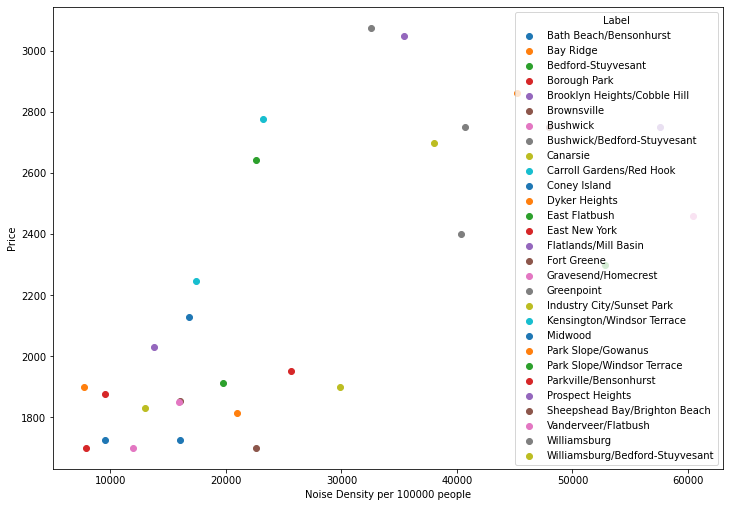

In [968]:
total_complaints_byzip = b_df.groupby(by = ['Complaint Type', 'Zip']).count()
total_complaints_byzip.to_csv("tmp.csv")
total_complaints_byzip = pd.read_csv("tmp.csv")
total_complaints_byzip = total_complaints_byzip.drop(['Unique Key', 'City', 'Borough', 'Created Date'], axis=1)
total_complaints_byzip.rename(columns={"Unnamed: 0": "Count"}, inplace = True)
# total_noise_row_byzip = {'Complaint Type':'Total Noise', 'Count':656125}
# total_complaints_byzip = total_complaints.append(total_noise_row, ignore_index=True)
# total_complaints_byzip = total_complaints.sort_values(ascending = False, by='Count')
total_complaints_byzip_noise = total_complaints_byzip[total_complaints_byzip['Complaint Type'].str.contains('Noise')]
total_complaints_byzip_noise = total_complaints_byzip_noise.groupby('Zip').sum()
total_complaints_byzip_noise.to_csv("tmp.csv")
total_complaints_byzip_noise = pd.read_csv("tmp.csv")
total_complaints_byzip_noise = pd.merge(total_complaints_byzip_noise, pop_df, on="Zip")
total_complaints_byzip_noise['Noise Density per 100,000'] = round(total_complaints_byzip_noise['Count']*100000/total_complaints_byzip_noise['Population'],2)
total_complaints_byzip_noise = pd.merge(total_complaints_byzip_noise, zip_df, on="Zip")
# total_complaints_byzip_noise
rent_df.groupby(["Neighborhood"])['Price'].median()
total_complaints_byzip_noise = pd.merge(total_complaints_byzip_noise, rent_df.groupby(["Neighborhood"])['Price'].median(), on="Neighborhood")
total_complaints_byzip_noise


fig, ax = plt.subplots(figsize=(12,8.5))

for n, grp in total_complaints_byzip_noise.groupby('Neighborhood'):
    ax.scatter(x = "Noise Density per 100,000", y = "Price", data=grp, label=n)
plt.xlabel("Noise Density per 100000 people")
plt.ylabel("Price")
ax.legend(title="Label")

total_complaints_byzip_noise.sort_values(by='Price')


In [934]:
import plotly.graph_objects as go

ignore_noise = ['Noise - Residential', 'Noise - Street/Sidewalk', 'Noise', 'Noise - Commercial', 'Noise - Vehicle',
               'Noise - Park', 'Noise - House of Worship', 'Noise - Helicopter', 'Collection Truck Noise']
# total_complaints = b_df[b_df['Complaint Type'].str.contains("Noise")].groupby(by = ['Complaint Type']).count().sort_values(ascending = True, by='Unique Key').reset_index()
total_complaints = total_complaints[~total_complaints['Complaint Type'].isin(ignore_noise)][0:20].sort_values(ascending = True, by='Count')
fig = go.Figure(go.Bar(
            x=total_complaints['Count'],
            y=total_complaints['Complaint Type'],
            orientation='h'),
               go.Layout(title = "Distribution of All Complaints")
               )

fig.show()

In [862]:
complaints = ['Illegal Parking', 
        'Noise - Commercial', 'Noise - Residential',
       'Derelict Vehicle',
       'Indoor Air Quality', 'Noise - Street/Sidewalk', 'Noise - Park',
       'Non-Emergency Police Matter', 'Noise - Vehicle',
       'Blocked Driveway', 'Drinking', 'Vending', 'Food Establishment',
       'BEST/Site Safety',
       'General Construction/Plumbing', 'Unsanitary Animal Pvt Property',
       'Sidewalk Condition', 'Air Quality', 'Noise', 
       'Lead', 'Street Condition',
       'Hazardous Materials','Curb Condition',
       'Root/Sewer/Sidewalk Condition',
       'Special Projects Inspection Team (SPIT)', 'Building/Use',
       'Graffiti', 'Construction', 
       'Bus Stop Shelter Complaint', 'Asbestos','Water Quality',
       'Industrial Waste', 'Emergency Response Team (ERT)',
       'Noise - House of Worship',
       'Homeless Encampment', 'Miscellaneous Categories', 
       'Derelict Vehicles', 'Sanitation Condition', 'Smoking',
       'Overflowing Litter Baskets', 'Homeless Person Assistance',
       'Other Enforcement', 'PAINT/PLASTER', 
       'Derelict Bicycle', 'GENERAL', 'Dirty Conditions',
       'ELECTRIC', 
       'Missed Collection (All Materials)', 'Litter Basket / Request',
       'Sweeping/Missed', 'SAFETY', 'UNSANITARY CONDITION', 
       'Broken Parking Meter',
       'Construction Safety Enforcement', 
       'Drug Activity',
       'DOF Property - Payment Issue', 'Building Marshals office',
       'Borough Office']

In [863]:
b_df_copy = b_df.copy()

In [864]:
# count_df = df1[['Creation Date','Complaint Type','Incident Zip']].groupby([pd.Grouper(key='Created Date', freq='Y'),'Complaint Type','Incident Zip'])['id'].count().reset_index(name="count")
count_b_df = b_df.groupby(by = ['Complaint Type', 'Zip', pd.Grouper(key='Created Date', freq='M')]).count()
count_b_df.to_csv("b_counted_complaints.csv")
# resetting index did not help as after groupby the columns that were used for sorting stopped being columns
count_b_df = pd.read_csv("b_counted_complaints.csv")
# combine Brooklyn data set with population per zip code
count_b_df = pd.merge(count_b_df, pop_df, on="Zip")
count_b_df = pd.merge(count_b_df, zip_df, on="Zip")
count_b_df.rename(columns={"Unique Key": "Count"}, inplace = True)
count_b_df['Incident Density'] = count_b_df['Count']*100000/count_b_df['Population']
count_b_df



,Complaint Type,Zip,Created Date,Unnamed: 0,Count,City,Borough,Population,Neighborhood,Incident Density
0,AGENCY,11204,2016-02-29,1,1,1,1,76395,Parkville/Bensonhurst,1.308986
1,APPLIANCE,11204,2014-01-31,1,1,1,1,76395,Parkville/Bensonhurst,1.308986
2,APPLIANCE,11204,2014-02-28,1,1,1,1,76395,Parkville/Bensonhurst,1.308986
3,APPLIANCE,11204,2014-03-31,2,2,2,2,76395,Parkville/Bensonhurst,2.617972
4,APPLIANCE,11204,2014-04-30,5,5,5,5,76395,Parkville/Bensonhurst,6.544931
...,...,...,...,...,...,...,...,...,...,...
210020,Water System,11239,2018-11-30,4,4,4,4,12772,Starrett City,31.318509
210021,Water System,11239,2018-12-31,5,5,5,5,12772,Starrett City,39.148137
210022,Water System,11239,2019-01-31,8,8,8,8,12772,Starrett City,62.637018
210023,Water System,11239,2019-02-28,2,2,2,2,12772,Starrett City,15.659255


In [865]:
# for name in complaints: # count_b_df['Complaint Type'].unique():
name = "Homeless Encampment"
px.line(count_b_df[count_b_df['Complaint Type']==name], x='Created Date', y='Incident Density', color='Neighborhood',title=name, 
#         labels={
#                  "Incident Density": name
#              }
       ).show()

In [866]:
noise_df = count_b_df[count_b_df['Complaint Type'].str.contains("Noise")]   
# count_b_df[count_b_df['Complaint Type'].str.contains("Noise")].groupby(by = ['Created Date', 'Zip']).sum()
noise_df = noise_df.drop(['City', 'Borough', 'Population', 'Incident Density', 'Neighborhood'], axis=1)
                                                                                                                                              

In [867]:
# before taking top 5 normalize by population. And then take top 5 in population density. 
total_noise_by_zip_df = noise_df.groupby(["Zip"]).sum()
total_noise_by_zip_df = pd.merge(total_noise_by_zip_df, pop_df, on="Zip")
total_noise_by_zip_df["Density per 100000 people"] = round(total_noise_by_zip_df["Count"]*100000/total_noise_by_zip_df["Population"],2)
total_noise_by_zip_df = pd.merge(total_noise_by_zip_df, zip_df, on="Zip")

top5noise_neighborhoods = total_noise_by_zip_df.groupby(["Neighborhood"]).sum()["Density per 100000 people"].nlargest(n=5).index.tolist()
bottom5noise_neighborhoods = total_noise_by_zip_df.groupby(["Neighborhood"]).sum()["Density per 100000 people"].nsmallest(n=5).index.tolist()
bottom10noise_neighborhoods = total_noise_by_zip_df.groupby(["Neighborhood"]).sum()["Density per 100000 people"].nsmallest(n=10).index.tolist()


In [868]:
all_noise_df = noise_df.groupby(by = ['Created Date', 'Zip']).sum()
all_noise_df.to_csv("all_noise.csv")
all_noise_df = pd.read_csv("all_noise.csv")
all_noise_df = pd.merge(all_noise_df, zip_df, on="Zip")
all_noise_df = pd.merge(all_noise_df, pop_df, on="Zip")
all_noise_df["Density per 100000 people"] = round(all_noise_df["Count"]*100000/all_noise_df["Population"],2)
all_noise_df['Created Date'] = pd.to_datetime(all_noise_df['Created Date'])

extreme_noise_df = all_noise_df[all_noise_df['Neighborhood'].isin(top5noise_neighborhoods+bottom5noise_neighborhoods)]
high_noise_df = all_noise_df[all_noise_df['Neighborhood'].isin(top5noise_neighborhoods)]
low_noise_df = all_noise_df[all_noise_df['Neighborhood'].isin(bottom5noise_neighborhoods)]


In [869]:
px.line(extreme_noise_df, x='Created Date', y='Density per 100000 people', color='Neighborhood',title="All Noise").show()

In [870]:
rent_df = pd.read_csv("rent_cleaned.csv")
rent_df = rent_df.drop(["Borough", "areaType"], axis=1)
rent_df = rent_df.drop(["Unnamed: 0"], axis=1)
rent_df = rent_df.set_index("Neighborhood")
rent_df = rent_df.T.stack(dropna=False)
rent_df.to_csv("test.csv")
rent_df = pd.read_csv("test.csv")
rent_df.columns = ["Created Date", "Neighborhood", "Price"]
rent_df.sort_values(by=["Neighborhood", "Created Date"])

top5rents = rent_df.groupby(["Neighborhood"])['Price'].median().nlargest(n=5).index.tolist()
bottom5rents = rent_df.groupby(["Neighborhood"])['Price'].median().nsmallest(n=5).index.tolist()
bottom10rents = rent_df.groupby(["Neighborhood"])['Price'].median().nsmallest(n=10).index.tolist()


In [871]:
print(list(set(bottom5rents) & set(bottom5noise_neighborhoods)))
print(list(set(bottom10rents) & set(bottom10noise_neighborhoods)))

['Borough Park', 'Bath Beach/Bensonhurst']
['Canarsie', 'Vanderveer/Flatbush', 'Gravesend/Homecrest', 'Bath Beach/Bensonhurst', 'Borough Park']


In [872]:
rent_df['Created Date'] = pd.to_datetime(rent_df['Created Date'])
# to corrspond to the 311 data frame
rent_df['Created Date'] += pd.offsets.MonthEnd()
rent_df.dtypes

Created Date    datetime64[ns]
Neighborhood            object
Price                  float64
dtype: object

In [873]:
extreme_rent_df = rent_df[rent_df['Neighborhood'].isin(bottom5rents+top5rents)]
high_rent_df = rent_df[rent_df['Neighborhood'].isin(top5rents)]
low_rent_df = rent_df[rent_df['Neighborhood'].isin(bottom5rents)]


In [874]:
px.line(extreme_rent_df, x='Created Date', y='Price', color='Neighborhood',title="All Rents", 
       labels={"Created Date": "Date"
            },).show()

In [875]:
extreme_noise_df.dtypes

Created Date                 datetime64[ns]
Zip                                   int64
Unnamed: 0                            int64
Count                                 int64
Neighborhood                         object
Population                            int64
Density per 100000 people           float64
dtype: object

In [876]:
all_extreme_noise_price_df = pd.merge(extreme_noise_df, rent_df, how='left', on=["Neighborhood", "Created Date"])
all_extreme_noise_price_df

,Created Date,Zip,Unnamed: 0,Count,Neighborhood,Population,Density per 100000 people,Price
0,2013-06-30,11204,21,21,Parkville/Bensonhurst,76395,27.49,1350.0
1,2013-06-30,11204,21,21,Parkville/Bensonhurst,76395,27.49,2100.0
2,2013-07-31,11204,112,112,Parkville/Bensonhurst,76395,146.61,1400.0
3,2013-07-31,11204,112,112,Parkville/Bensonhurst,76395,146.61,2100.0
4,2013-08-31,11204,109,109,Parkville/Bensonhurst,76395,142.68,1450.0
...,...,...,...,...,...,...,...,...
786,2019-01-31,11239,10,10,Starrett City,12772,78.30,NaN
787,2019-02-28,11239,15,15,Starrett City,12772,117.44,NaN
788,2019-03-31,11239,12,12,Starrett City,12772,93.96,NaN
789,2019-04-30,11239,45,45,Starrett City,12772,352.33,NaN


In [877]:
all_extreme_noise_price_df[all_extreme_noise_price_df["Price"].isna()]

,Created Date,Zip,Unnamed: 0,Count,Neighborhood,Population,Density per 100000 people,Price
432,2013-06-30,11225,46,46,Crown Heights,56859,80.90,NaN
433,2013-07-31,11225,284,284,Crown Heights,56859,499.48,NaN
434,2013-08-31,11225,347,347,Crown Heights,56859,610.28,NaN
435,2013-09-30,11225,332,332,Crown Heights,56859,583.90,NaN
436,2013-10-31,11225,301,301,Crown Heights,56859,529.38,NaN
...,...,...,...,...,...,...,...,...
786,2019-01-31,11239,10,10,Starrett City,12772,78.30,NaN
787,2019-02-28,11239,15,15,Starrett City,12772,117.44,NaN
788,2019-03-31,11239,12,12,Starrett City,12772,93.96,NaN
789,2019-04-30,11239,45,45,Starrett City,12772,352.33,NaN


In [883]:
all_extreme_noise_price_df.groupby('Zip')[['Density per 100000 people','Price']].corr()

Density per 100000 people     Price
Zip                                                                 
11204 Density per 100000 people                   1.000000  0.090045
      Price                                       0.090045  1.000000
11205 Density per 100000 people                   1.000000  0.148696
      Price                                       0.148696  1.000000
11214 Density per 100000 people                   1.000000  0.673749
      Price                                       0.673749  1.000000
11216 Density per 100000 people                   1.000000  0.430811
      Price                                       0.430811  1.000000
11219 Density per 100000 people                   1.000000  0.357872
      Price                                       0.357872  1.000000
11225 Density per 100000 people                   1.000000       NaN
      Price                                            NaN       NaN
11228 Density per 100000 people                   1.000000  0.264778
      Price                                       0.264778  1.000000
11237 Density per 100000 people                   1.000000  0.687986
      Price                                       0.687986  1.000000
11238 Density per 100000 people                   1.000000  0.611046
      Price                                       0.611046  1.000000
11239 Density per 100000 people                   1.000000       NaN
      Price                                            NaN       NaN

Bath Beach/Bensonhurst
Bedford-Stuyvesant
Borough Park
Bushwick
Crown Heights
Dyker Heights
Fort Greene
Parkville/Bensonhurst
Prospect Heights
Starrett City


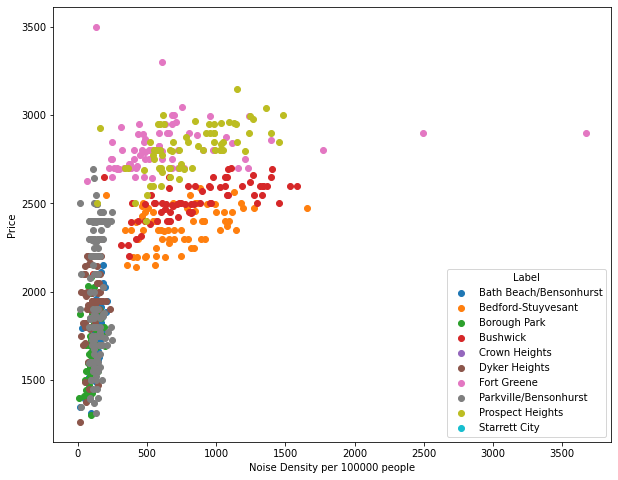

In [884]:
# df = pd.DataFrame(np.random.randint(0,10,size=(5, 2)), columns=['x','y'])
# df['label'] = ['yes','no','yes','yes','no']

# plot groupby results on the same canvas 
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(10,8))

for n, grp in all_extreme_noise_price_df.groupby('Neighborhood'):
    print(n)
    ax.scatter(x = "Density per 100000 people", y = "Price", data=grp, label=n)
plt.xlabel("Noise Density per 100000 people")
plt.ylabel("Price")
ax.legend(title="Label")

In [885]:
import plotly.graph_objects as go

extreme_rent_df1 = extreme_rent_df.groupby('Neighborhood')['Price'].median().sort_values(ascending = False).reset_index()

fig = go.Figure(go.Bar(
            x=extreme_rent_df1['Price'],
            y=extreme_rent_df1['Neighborhood'],
            orientation='h'),
               go.Layout(title = "Neighborhood with Highest and Lowest Median Rent Prices")
               )

fig.show()


In [887]:
all_extreme_noise_price_df1 = all_extreme_noise_price_df.groupby('Neighborhood')['Density per 100000 people'].median().sort_values(ascending = False).reset_index()

fig = go.Figure(go.Bar(
            x=all_extreme_noise_price_df1['Density per 100000 people'],
            y=all_extreme_noise_price_df1['Neighborhood'],
            orientation='h'),
               go.Layout(title = "Neighborhood with Highest and Lowest Median Noise Density (per 100,000 population)"))

fig.show()


In [888]:
all_extreme_noise_price_df

,Created Date,Zip,Unnamed: 0,Count,Neighborhood,Population,Density per 100000 people,Price
0,2013-06-30,11204,21,21,Parkville/Bensonhurst,76395,27.49,1350.0
1,2013-06-30,11204,21,21,Parkville/Bensonhurst,76395,27.49,2100.0
2,2013-07-31,11204,112,112,Parkville/Bensonhurst,76395,146.61,1400.0
3,2013-07-31,11204,112,112,Parkville/Bensonhurst,76395,146.61,2100.0
4,2013-08-31,11204,109,109,Parkville/Bensonhurst,76395,142.68,1450.0
...,...,...,...,...,...,...,...,...
786,2019-01-31,11239,10,10,Starrett City,12772,78.30,NaN
787,2019-02-28,11239,15,15,Starrett City,12772,117.44,NaN
788,2019-03-31,11239,12,12,Starrett City,12772,93.96,NaN
789,2019-04-30,11239,45,45,Starrett City,12772,352.33,NaN
